# pipeline

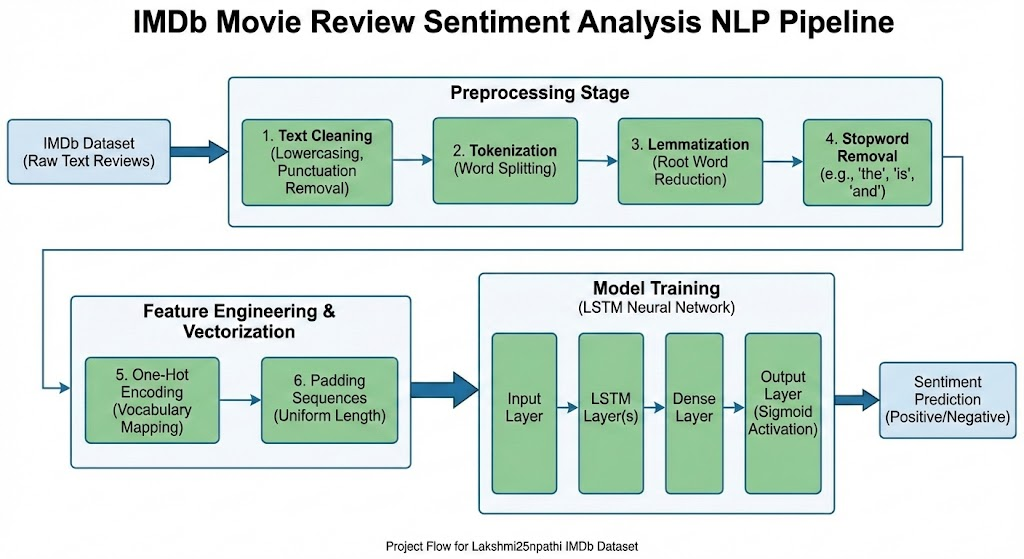

### 📌 Project Summary

This project builds a **Sentiment Analysis model** using an **LSTM neural network** trained on the IMDB movie review dataset.  
The model classifies text reviews into **positive** or **negative** sentiment.

It can be used for:
- Analyzing customer reviews
- Monitoring social media reactions
- Improving chatbot responses
- Automating feedback understanding

The goal is to help systems automatically understand user emotions and opinions from text.


clean → tokenize → lemmatize → remove stopwords → one-hot → pad → LSTM


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)



Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [4]:
#load the dataset
df = pd.read_csv(f'{path}/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
# basic analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.shape

(50000, 2)

#Step 1: Clean the text (optional but recommended)

In [7]:
# here we see we have 418 duplicated values
df[df.duplicated()]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [8]:
# we dropped duplicates values
df = df.drop_duplicates()

In [9]:
df.shape

(49582, 2)

In [ ]:
# here we can see there are symbols and other charcters that they not important
# we have to clean them
print(df['review'][1])

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.


In [10]:
import re

cleaned_text = []
for text in df['review']:

  text = re.sub(r'[^a-zA-Z\s]',"",text) # this is removing all unecessary things
  text = re.sub(r'\s+'," ",text).strip() # remove uneccesary space
  text = text.lower() # lowering the text
  cleaned_text.append(text)

df.loc[:,"clean_review"] = cleaned_text

/tmp/ipython-input-3915934303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"clean_review"] = cleaned_text


In [ ]:
df['clean_review']

,clean_review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production br br the filmin...
2,i thought this was a wonderful way to spend ti...
3,basically theres a family where a little boy j...
4,petter matteis love in the time of money is a ...
...,...
49995,i thought this movie did a down right good job...
49996,bad plot bad dialogue bad acting idiotic direc...
49997,i am a catholic taught in parochial elementary...
49998,im going to have to disagree with the previous...


#step 2 tokenization

In [11]:
# now apply tokanization

from tensorflow.keras.preprocessing.text import Tokenizer

voc_size = 20000

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(df['clean_review'])

In [ ]:
df['clean_review'][1]

'a wonderful little production br br the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece br br the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life br br the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done'

# step 4 : ✅ Standalone Lemmatization Code

In [12]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

# Stopwords (keep negations for sentiment analysis)

important_words = {"not","no","never"}
stop_words = set([w for w in stopwords.words('english') if w not in important_words])

def lemmatize_text(text):

  tokens = text.split()
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
  return " ".join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#remove all stopwords

In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))

def remove_stopword(text):
  return " ".join([word for word in text.split() if word not in stop_words])

df['clean_review'] = df['clean_review'].apply(remove_stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-2477590847.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_review'] = df['clean_review'].apply(remove_stopword)


#Step 4: Convert labels (sentiment) → 0/1

In [14]:
df['sentiment'] = df['sentiment'].map({'positive':1,'negative':0})


/tmp/ipython-input-3796667729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].map({'positive':1,'negative':0})


# step 5 : One Hot Encode Each Review

In [15]:
from tensorflow.keras.preprocessing.text import one_hot
voc_size = 20000

onehot_repr = [one_hot(review, voc_size) for review in df['clean_review']]
print(onehot_repr[:5])  # show first 5 encoded reviews


[[19936, 17243, 750, 391, 13967, 10675, 2587, 15513, 6923, 8381, 13042, 18738, 10392, 5758, 9386, 13591, 13967, 17472, 11352, 19822, 3336, 6142, 6923, 8467, 19096, 13276, 18087, 13740, 553, 17546, 18087, 13281, 3505, 12751, 3019, 13861, 3336, 11343, 2816, 17657, 8908, 10392, 15583, 13967, 17242, 8568, 2672, 4481, 12427, 6076, 14679, 10967, 9013, 3139, 14690, 10352, 12089, 17119, 467, 2187, 3217, 17394, 19467, 11415, 17589, 14619, 15579, 14690, 9864, 11579, 14597, 8583, 8899, 5988, 9994, 5804, 8717, 13801, 9027, 15708, 6313, 2790, 16043, 5995, 5613, 16494, 5074, 10392, 15510, 10060, 5371, 6479, 18087, 1398, 18006, 6439, 8132, 15794, 5231, 6083, 10531, 19835, 10819, 15008, 16908, 6083, 8213, 6083, 12433, 11712, 7566, 18507, 5758, 10675, 985, 18185, 13591, 10390, 5709, 19047, 10060, 1719, 18694, 5496, 18370, 13967, 18959, 4776, 17589, 3956, 17190, 3336, 3336, 13737, 9397, 7215, 2226, 14751, 16287, 6166, 2226, 82, 14746, 8396, 1240, 16591, 15800, 2741, 4759, 6166, 2804, 17119, 16481, 1398,

#Padding (Pre-padding)
in our datset each sentence is not same , but in nlp for training it has to be same

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

set_length = 200  # IMDB sentences are no longer than the 200 words or characters

emmbedded_doc = pad_sequences(onehot_repr , padding = 'pre', maxlen = set_length)

print(emmbedded_doc.shape)
print(emmbedded_doc)

(49582, 200)
[[    0     0     0 ... 15088  7689 17806]
 [    0     0     0 ...  2023 16591 16795]
 [    0     0     0 ... 19096 12818  8820]
 ...
 [    0     0     0 ... 10197 15220 15660]
 [    0     0     0 ...   312  4443 13198]
 [    0     0     0 ...  4394  5753  9640]]


In [17]:
x = emmbedded_doc
print(x)
print(x.shape)

[[    0     0     0 ... 15088  7689 17806]
 [    0     0     0 ...  2023 16591 16795]
 [    0     0     0 ... 19096 12818  8820]
 ...
 [    0     0     0 ... 10197 15220 15660]
 [    0     0     0 ...   312  4443 13198]
 [    0     0     0 ...  4394  5753  9640]]
(49582, 200)


In [18]:
y = df['sentiment'].values
print(y)
print(y.shape)

[1 1 1 ... 0 0 0]
(49582,)


# train test split

In [19]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state=42)

#we are now training with deep learning model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout

model = Sequential()  # save the model
model.add(Embedding(voc_size,200,input_length = set_length))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
model.build(input_shape=(None,set_length))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,120,501 (15.72 MB)

 Trainable params: 4,120,501 (15.72 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [30]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test,y_test),
    # callbacks=[early_stop]
)


Epoch 1/10
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9869 - loss: 0.0384 - val_accuracy: 0.8374 - val_loss: 0.6851
Epoch 2/10
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9934 - loss: 0.0219 - val_accuracy: 0.8407 - val_loss: 0.7285
Epoch 3/10
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9928 - loss: 0.0219 - val_accuracy: 0.8369 - val_loss: 0.8139
Epoch 4/10
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9977 - loss: 0.0092 - val_accuracy: 0.8441 - val_loss: 0.8473
Epoch 5/10
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9951 - loss: 0.0154 - val_accuracy: 0.8453 - val_loss: 0.8263
Epoch 6/10
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9973 - loss: 0.0107 - val_accuracy: 0.8383 - val_loss: 0.7747
Epoch 7/10
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9978 - loss: 0.0092 - val_accuracy: 0.8384 - val_loss: 0.7573
Epoch 8/10
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9979 -

#Performance Metrics And Accuracy

In [31]:
y_pred = model.predict(x_test)

388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [32]:
y_pred=np.where(y_pred > 0.6, 1,0) ##AUC ROC Curve

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[5178,  990],
       [1071, 5157]])

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8337366892545982

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      6168
           1       0.84      0.83      0.83      6228

    accuracy                           0.83     12396
   macro avg       0.83      0.83      0.83     12396
weighted avg       0.83      0.83      0.83     12396



# now save file in pickle

In [36]:
import pickle

with open ('IMDB_pickle.pickle',"wb") as f:
  pickle.dump(model,f)